In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt



#Load our Data

In [ ]:
url = "https://data.cityofchicago.org/api/views/6iiy-9s97/rows.csv?accessType=DOWNLOAD"
df = pd.read_csv(url, parse_dates=["service_date"])
df.columns = ["date", "day_type", "bus", "rail", "total"]
df = df.sort_values("date").set_index("date")


# Dara Exploration

In [ ]:
df = df.drop("total", axis=1)
df = df.drop_duplicates()

In [ ]:
df

,day_type,bus,rail
date,,,
2001-01-01,U,297192,126455
2001-01-02,W,780827,501952
2001-01-03,W,824923,536432
2001-01-04,W,870021,550011
2001-01-05,W,890426,557917
...,...,...,...
2025-04-26,A,428587,317347
2025-04-27,U,329874,245932
2025-04-28,W,604201,393731


<Axes: xlabel='date'>

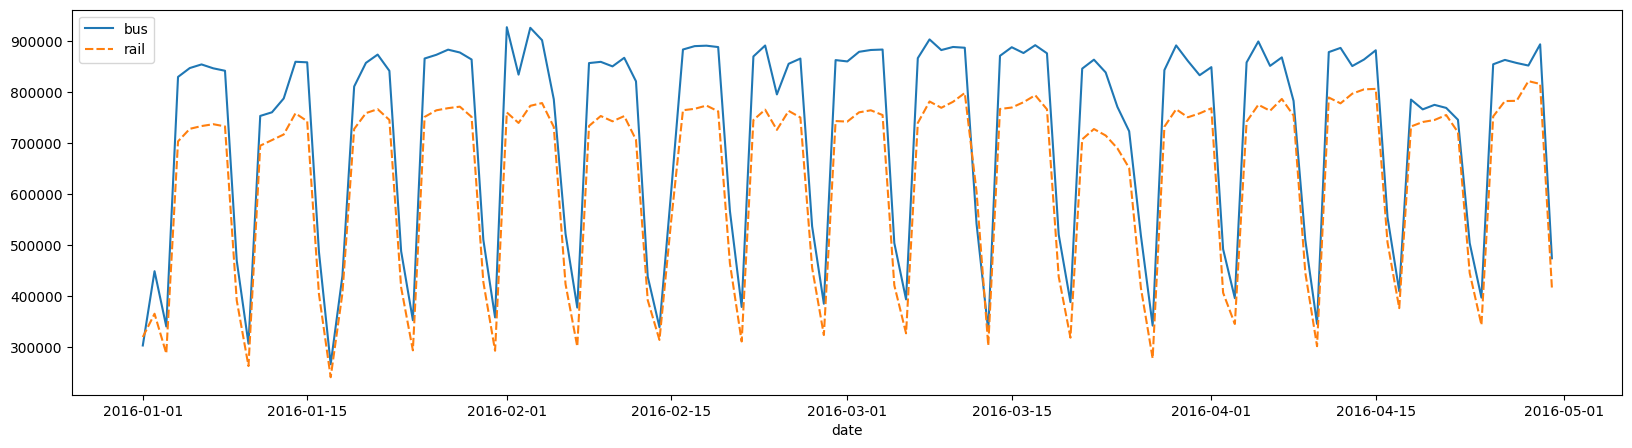

In [ ]:
plt.figure(figsize=(20, 5))
sns.lineplot(df['2016-01':'2016-04'])

<Axes: xlabel='date'>

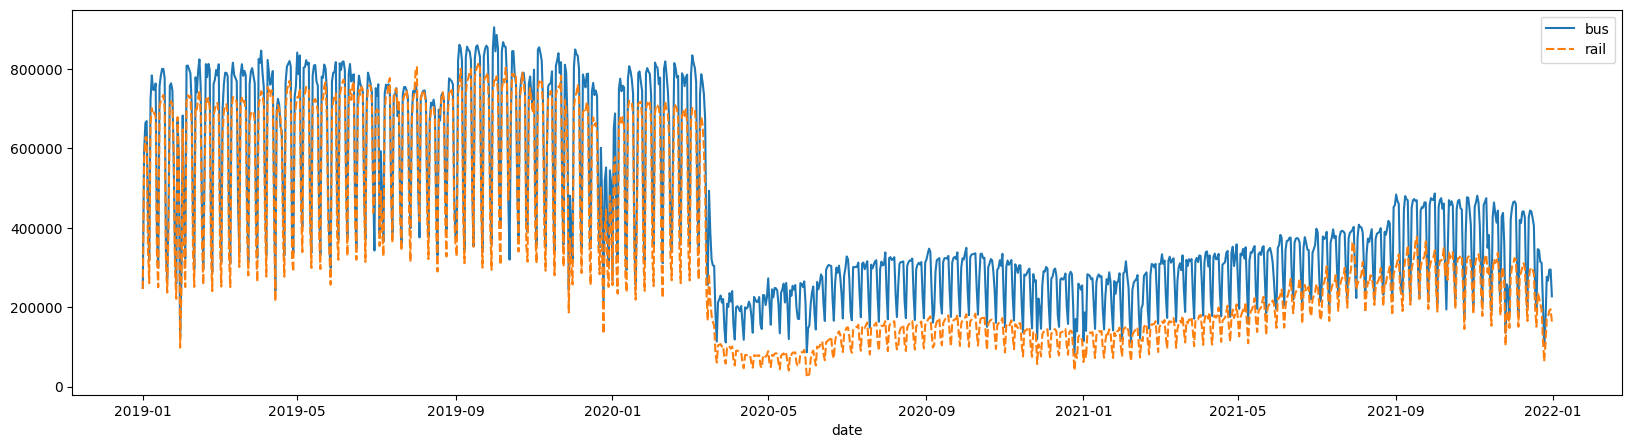

In [ ]:
plt.figure(figsize=(20, 5))
sns.lineplot(df['2019':'2021'])

<Axes: xlabel='date'>

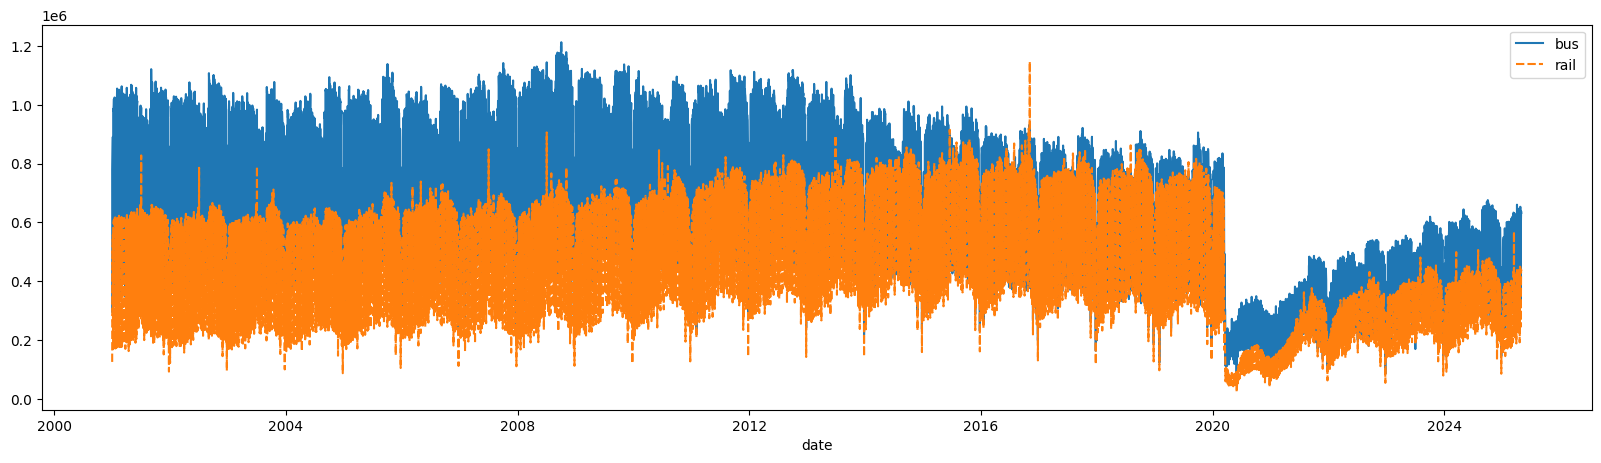

In [ ]:
plt.figure(figsize=(20, 5))
sns.lineplot(df)

In [ ]:
df['next_day_type']=df['day_type'].shift(-1)

In [ ]:
df

,day_type,bus,rail,next_day_type
date,,,,
2001-01-01,U,297192,126455,W
2001-01-02,W,780827,501952,W
2001-01-03,W,824923,536432,W
2001-01-04,W,870021,550011,W
2001-01-05,W,890426,557917,A
...,...,...,...,...
2025-04-26,A,428587,317347,U
2025-04-27,U,329874,245932,W
2025-04-28,W,604201,393731,W


In [ ]:
df[['A','U','W']]=pd.get_dummies(df['day_type'],dtype=int)
df[['Anext','Unext','Wnext']]=pd.get_dummies(df['next_day_type'],dtype=int)

In [ ]:
df.drop(['day_type','next_day_type'],inplace=True,axis=1)

In [ ]:
df[['bus','rail']]=df[['bus','rail']]/1e6

In [ ]:
df

,bus,rail,A,U,W,Anext,Unext,Wnext
date,,,,,,,,
2001-01-01,0.297192,0.126455,0,1,0,0,0,1
2001-01-02,0.780827,0.501952,0,0,1,0,0,1
2001-01-03,0.824923,0.536432,0,0,1,0,0,1
2001-01-04,0.870021,0.550011,0,0,1,0,0,1
2001-01-05,0.890426,0.557917,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...
2025-04-26,0.428587,0.317347,1,0,0,0,1,0
2025-04-27,0.329874,0.245932,0,1,0,0,0,1
2025-04-28,0.604201,0.393731,0,0,1,0,0,1


# Let's make our train, validation and test sets

In [ ]:
train=df['2001':'2015']
valid=df['2016':'2019']
test=df['2023':]

In [ ]:
len(train),len(valid),len(test)

(5478, 1461, 851)

In [ ]:

train_ds=tf.keras.utils.timeseries_dataset_from_array(train,
                                                      sequence_length=14,
                                                      targets=train['rail'][14:],
                                                      batch_size=32,
                                                      shuffle=True)
valid_ds=tf.keras.utils.timeseries_dataset_from_array(valid,
                                                      sequence_length=14,
                                                      targets=valid['rail'][14:],
                                                      batch_size=32
                                                      )
test_ds=tf.keras.utils.timeseries_dataset_from_array(test,
                                                     sequence_length=14,
                                                     targets=test['rail'][14:],
                                                     batch_size=32
                                                     )

# Model_1

In [ ]:
model_1=tf.keras.Sequential([
    tf.keras.layers.Input(shape=(14,8)),
    tf.keras.layers.LSTM(345,return_sequences=True),
    tf.keras.layers.LSTM(345,return_sequences=True),
    tf.keras.layers.GRU(345),
    tf.keras.layers.Dense(1)
])
model_1.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 14, 345)        │       488,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 14, 345)        │       953,580 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 345)            │       716,220 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           346 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,158,666 (8.23 MB)

 Trainable params: 2,158,666 (8.23 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
def lr_schedule_exp(epoch):
  if epoch<50:
    return float(tf.exp(-epoch/10.)*0.01)/2
  else:
    return 0.0001/5
learning_rate_callback=tf.keras.callbacks.LearningRateScheduler(lr_schedule_exp)
checkpoint=tf.keras.callbacks.ModelCheckpoint('model.keras',monitor='val_loss',mode='min',save_best_only=True,verbose=1)

In [ ]:
model_1.compile(loss='mae',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['mae'])

In [ ]:
history_1=model_1.fit(train_ds,
            epochs=100,
            validation_data=valid_ds,
            verbose=1,callbacks=[learning_rate_callback,checkpoint])

Epoch 1/100
166/171 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3502 - mae: 0.3502
Epoch 1: val_loss improved from inf to 0.04957, saving model to model.keras
171/171 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - loss: 0.3429 - mae: 0.3429 - val_loss: 0.0496 - val_mae: 0.0496 - learning_rate: 0.0050
Epoch 2/100
169/171 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0430 - mae: 0.0430
Epoch 2: val_loss improved from 0.04957 to 0.04672, saving model to model.keras
171/171 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0430 - mae: 0.0430 - val_loss: 0.0467 - val_mae: 0.0467 - learning_rate: 0.0045
Epoch 3/100
168/171 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0375 - mae: 0.0375
Epoch 3: val_loss did not improve from 0.04672
171/171 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0374 - mae: 0.0374 - val_loss: 0.0658 - val_mae: 0.0658 - learning_rate: 0.0041
Epoch 4/100
167/171 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0360 - mae: 0.0360
Epoch 4: val_loss improved from 0.04672 to 0.03729, saving model to m

<Axes: >

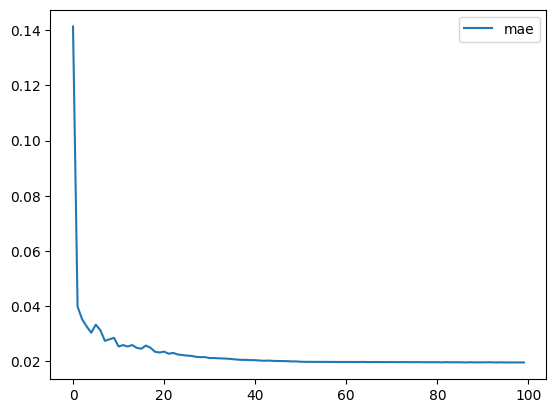

In [ ]:
sns.lineplot(history_1.history['mae'],label='mae')


In [ ]:
loss,mae=model_1.evaluate(valid_ds)

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0270 - mae: 0.0270


In [ ]:
loss*1e6

28140.760958194733

In [ ]:
pred=model_1.predict(valid_ds)

46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


In [ ]:
pred_df=pd.DataFrame(pred,index=valid.index[14:])

In [ ]:
pred_df['2016':]

,0
date,
2016-01-15,0.754909
2016-01-16,0.445945
2016-01-17,0.309426
2016-01-18,0.693337
2016-01-19,0.593275
...,...
2019-12-27,0.485739
2019-12-28,0.323004
2019-12-29,0.271400


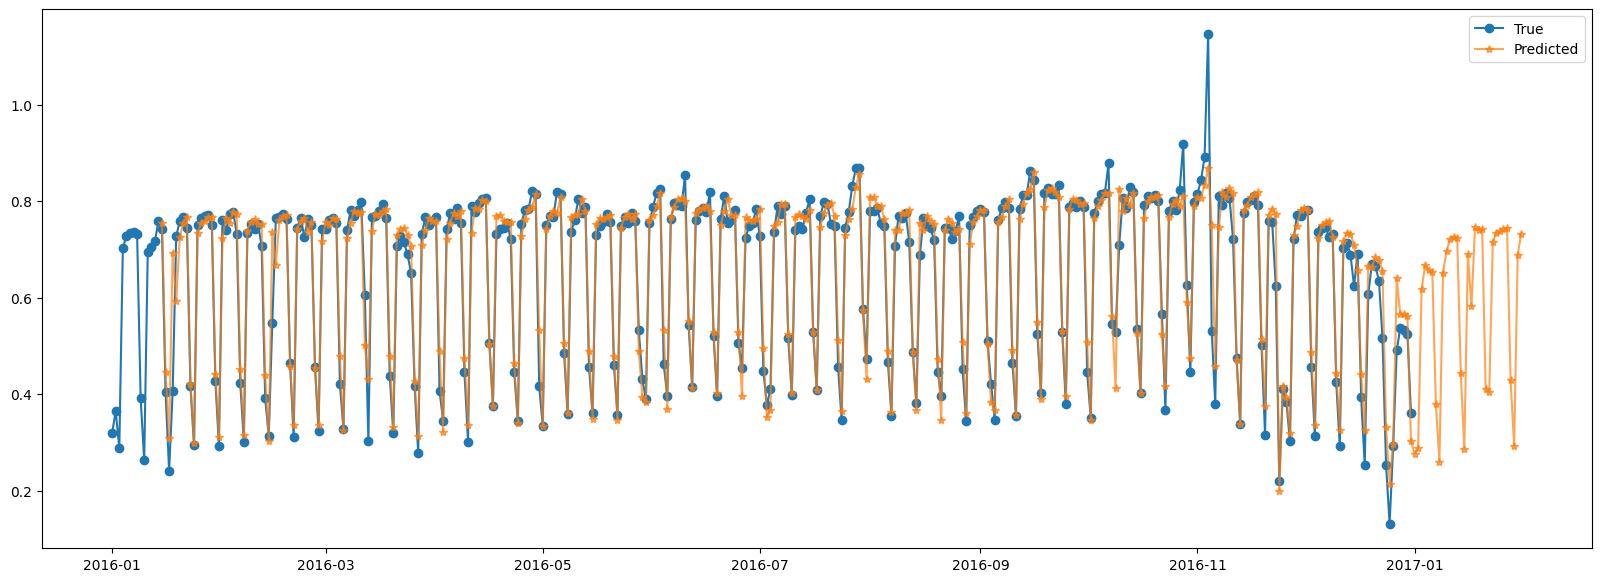

In [ ]:
plt.figure(figsize=(20,7))
plt.plot(valid['rail']['2016'],marker='o',label='True')
plt.plot(pred_df['2016-01':'2017-01'],marker='*',alpha=0.7,label='Predicted')
plt.legend()


In [ ]:
from sklearn.metrics import r2_score

In [ ]:
score=r2_score(valid['rail'][14:],pred)
print(f'We have an r2 score of {score*100:.2f}%')

We have an r2 score of 93.06%


# Model_2

In [ ]:
model_2=tf.keras.Sequential([
    tf.keras.layers.Input(shape=(14,8)),
    tf.keras.layers.LSTM(666,return_sequences=True),
    tf.keras.layers.LSTM(345,return_sequences=True,kernel_initializer='he_normal'),
    tf.keras.layers.GRU(250,return_sequences=True,kernel_initializer='he_normal'),
    tf.keras.layers.GRU(108,return_sequences=False,kernel_initializer='he_normal'),
    tf.keras.layers.Dense(1)
])
model_2.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_18 (LSTM)                  │ (None, 14, 666)        │     1,798,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_19 (LSTM)                  │ (None, 14, 345)        │     1,396,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_6 (GRU)                     │ (None, 14, 250)        │       447,750 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_7 (GRU)                     │ (None, 108)            │       116,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 1)              │           109 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,759,259 (14.34 MB)

 Trainable params: 3,759,259 (14.34 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
def lr_schedule_exp(epoch):
  if epoch<80:
    return float(tf.exp(-epoch/10.)*0.01)/3
  else:
    return 0.0001/9
learning_rate_callback=tf.keras.callbacks.LearningRateScheduler(lr_schedule_exp)
checkpoint=tf.keras.callbacks.ModelCheckpoint('model_2.keras',monitor='val_loss',mode='min',save_best_only=True,verbose=1)

In [ ]:
model_2.compile(loss='mae',
                optimizer=tf.keras.optimizers.Nadam(),
                metrics=['mae'])

In [ ]:
history_2=model_2.fit(train_ds,
            epochs=100,
            validation_data=valid_ds,
            verbose=1,callbacks=[learning_rate_callback,checkpoint])

Epoch 1/100
168/171 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.4439 - mae: 0.4439
Epoch 1: val_loss improved from inf to 0.06350, saving model to model_2.keras
171/171 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - loss: 0.4372 - mae: 0.4372 - val_loss: 0.0635 - val_mae: 0.0635 - learning_rate: 0.0033
Epoch 2/100
168/171 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0497 - mae: 0.0497
Epoch 2: val_loss improved from 0.06350 to 0.04326, saving model to model_2.keras
171/171 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.0497 - mae: 0.0497 - val_loss: 0.0433 - val_mae: 0.0433 - learning_rate: 0.0030
Epoch 3/100
169/171 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0406 - mae: 0.0406
Epoch 3: val_loss improved from 0.04326 to 0.03829, saving model to model_2.keras
171/171 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.0406 - mae: 0.0406 - val_loss: 0.0383 - val_mae: 0.0383 - learning_rate: 0.0027
Epoch 4/100
169/171 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0326 - mae: 0.0326
Epoch 4: val_loss improved fro

<Axes: >

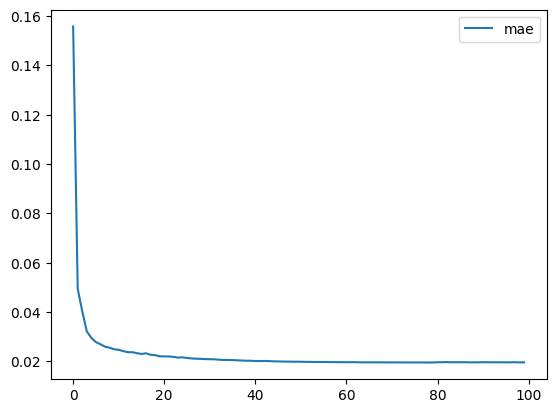

In [ ]:
sns.lineplot(history_2.history['mae'],label='mae')

In [ ]:
model_2.evaluate(valid_ds)

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0265 - mae: 0.0265


[0.027610167860984802, 0.027610167860984802]

In [ ]:
pred=model_2.predict(valid_ds)
score=r2_score(valid['rail'][14:],pred)
print(f'We have an r2 score of {score*100:.2f}%')

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
We have an r2 score of 93.10%


In [ ]:
pred_df=pd.DataFrame(pred,index=valid.index[14:])

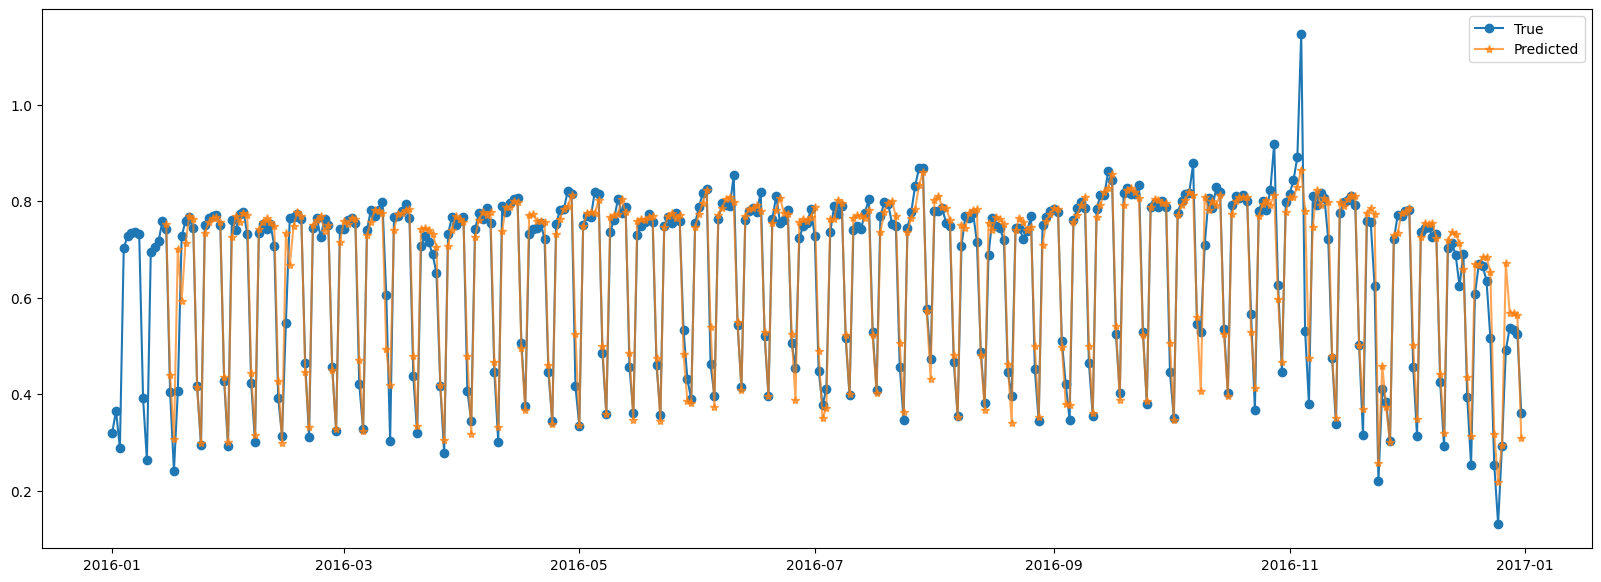

In [ ]:
plt.figure(figsize=(20,7))
plt.plot(valid['rail']['2016'],marker='o',label='True')
plt.plot(pred_df['2016-01':'2016-12'],marker='*',alpha=0.7,label='Predicted')
plt.legend()

# I will increase the sequence length to improve my model.

In [ ]:
len=30
train_ds=tf.keras.utils.timeseries_dataset_from_array(train,
                                                      sequence_length=len,
                                                      targets=train['rail'][len:],
                                                      batch_size=32,
                                                      shuffle=True)
valid_ds=tf.keras.utils.timeseries_dataset_from_array(valid,
                                                      sequence_length=len,
                                                      targets=valid['rail'][len:],
                                                      batch_size=32
                                                      )
test_ds=tf.keras.utils.timeseries_dataset_from_array(test,
                                                     sequence_length=len,
                                                     targets=test['rail'][len:],
                                                     batch_size=32
                                                     )

In [ ]:
model_2=tf.keras.Sequential([
    tf.keras.layers.Input(shape=(len,8)),
    tf.keras.layers.GRU(250,return_sequences=True),
    tf.keras.layers.GRU(108,return_sequences=False),
    tf.keras.layers.Dense(1)
])
model_2.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_10 (GRU)                    │ (None, 30, 250)        │       195,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_11 (GRU)                    │ (None, 108)            │       116,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 1)              │           109 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 311,749 (1.19 MB)

 Trainable params: 311,749 (1.19 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
def lr_schedule_exp(epoch):
  if epoch<80:
    return float(tf.exp(-epoch/10.)*0.01)/3
  else:
    return 0.0001/9
learning_rate_callback=tf.keras.callbacks.LearningRateScheduler(lr_schedule_exp)
checkpoint=tf.keras.callbacks.ModelCheckpoint('model_2.keras',monitor='val_loss',mode='min',save_best_only=True,verbose=1)

In [ ]:
model_2.compile(loss='mae',
                optimizer=tf.keras.optimizers.Nadam(),
                metrics=['mae'])

In [ ]:
history_2=model_2.fit(train_ds,
            epochs=100,
            validation_data=valid_ds,
            verbose=1,callbacks=[learning_rate_callback,checkpoint])

Epoch 1/100
167/171 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1206 - mae: 0.1206
Epoch 1: val_loss improved from inf to 0.04412, saving model to model_2.keras
171/171 ━━━━━━━━━━━━━━━━━━━━ 32s 14ms/step - loss: 0.1189 - mae: 0.1189 - val_loss: 0.0441 - val_mae: 0.0441 - learning_rate: 0.0033
Epoch 2/100
167/171 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0353 - mae: 0.0353
Epoch 2: val_loss improved from 0.04412 to 0.03946, saving model to model_2.keras
171/171 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0353 - mae: 0.0353 - val_loss: 0.0395 - val_mae: 0.0395 - learning_rate: 0.0030
Epoch 3/100
166/171 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0303 - mae: 0.0303
Epoch 3: val_loss improved from 0.03946 to 0.03710, saving model to model_2.keras
171/171 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0303 - mae: 0.0303 - val_loss: 0.0371 - val_mae: 0.0371 - learning_rate: 0.0027
Epoch 4/100
165/171 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0279 - mae: 0.0279
Epoch 4: val_loss improved fr

In [ ]:
model_2.evaluate(valid_ds)

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0249 - mae: 0.0249


[0.026371868327260017, 0.026371868327260017]

<Axes: >

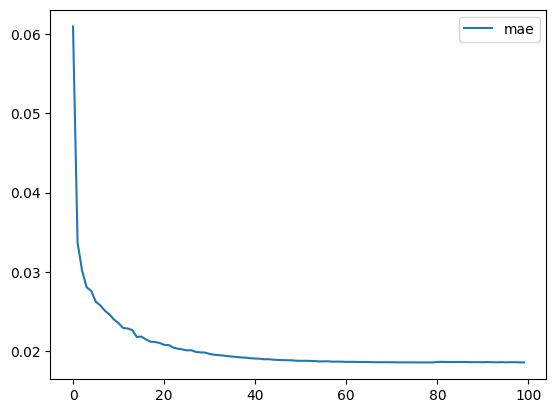

In [ ]:
sns.lineplot(history_2.history['mae'],label='mae')

In [ ]:
pred=model_2.predict(valid_ds)
score=r2_score(valid['rail'][30:],pred)
print(f'We have an r2 score of {score*100:.2f}%')

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
We have an r2 score of 93.52%


# I Will Use LeaveOneOut Encoder To Encode The Next Day Type

In [ ]:
df

,day_type,bus,rail,total
date,,,,
2001-01-01,U,297192,126455,423647
2001-01-02,W,780827,501952,1282779
2001-01-03,W,824923,536432,1361355
2001-01-04,W,870021,550011,1420032
2001-01-05,W,890426,557917,1448343
...,...,...,...,...
2025-04-26,A,428587,317347,745934
2025-04-27,U,329874,245932,575806
2025-04-28,W,604201,393731,997932


In [ ]:
df = df.drop("total", axis=1)
df = df.drop_duplicates()

In [ ]:
df['next_day_type']=df['day_type'].shift(-1)

In [ ]:
pip install category_encoders


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 3.7 MB/s eta 0:00:00


In [ ]:
from category_encoders.leave_one_out import LeaveOneOutEncoder

In [ ]:
encoder=LeaveOneOutEncoder()
encoded_df=encoder.fit_transform(df[['day_type','next_day_type']],df['rail'])

In [ ]:
encoded_df.rename(columns={'day_type':'day_type_enc','next_day_type':'next_day_type_enc'},inplace=True)

In [ ]:
df=pd.concat([encoded_df,df],axis=1)

In [ ]:
df.drop(['day_type','next_day_type'],inplace=True,axis=1)

In [ ]:
df

,day_type_enc,next_day_type_enc,bus,rail
date,,,,
2001-01-01,261764.413305,525290.039478,297192,126455
2001-01-02,595718.473252,525229.533999,780827,501952
2001-01-03,595712.917338,525223.978086,824923,536432
2001-01-04,595710.729294,525221.790042,870021,550011
2001-01-05,595709.455366,593396.097310,890426,557917
...,...,...,...,...
2025-04-26,360120.808544,362323.441218,428587,317347
2025-04-27,261679.857749,525270.787625,329874,245932
2025-04-28,595735.911376,525246.972124,604201,393731


In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()
df_scaled=scaler.fit_transform(df)
df_scaled

array([[0.00123766, 0.70454685, 0.19130771, 0.09164164],
       [0.99977142, 0.70428594, 0.61884585, 0.42601953],
       [0.99975481, 0.70426198, 0.65782716, 0.45672377],
       ...,
       [0.99982356, 0.70436114, 0.46270671, 0.32964936],
       [0.99980131, 0.70432905, 0.49266493, 0.37076526],
       [0.99980351, 0.63433264, 0.48758717, 0.36670816]])

In [ ]:
df_new=pd.DataFrame(df_scaled,columns=df.columns,index=df.index)

In [ ]:
df_new

,day_type_enc,next_day_type_enc,bus,rail
date,,,,
2001-01-01,0.001238,0.704547,0.191308,0.091642
2001-01-02,0.999771,0.704286,0.618846,0.426020
2001-01-03,0.999755,0.704262,0.657827,0.456724
2001-01-04,0.999748,0.704253,0.697694,0.468816
2001-01-05,0.999744,0.998236,0.715732,0.475856
...,...,...,...,...
2025-04-26,0.295327,0.001797,0.307462,0.261630
2025-04-27,0.000985,0.704464,0.220199,0.198035
2025-04-28,0.999824,0.704361,0.462707,0.329649


In [ ]:
train=df_new['2001':'2015']
valid=df_new['2016':'2019']
test=df_new['2023':]

In [ ]:
len=40
train_ds=tf.keras.utils.timeseries_dataset_from_array(train,
                                                      sequence_length=len,
                                                      targets=train['rail'][len:],
                                                      batch_size=32,
                                                      shuffle=True)
valid_ds=tf.keras.utils.timeseries_dataset_from_array(valid,
                                                      sequence_length=len,
                                                      targets=valid['rail'][len:],
                                                      batch_size=32
                                                      )
test_ds=tf.keras.utils.timeseries_dataset_from_array(test,
                                                     sequence_length=len,
                                                     targets=test['rail'][len:],
                                                     batch_size=32
                                                     )

In [ ]:
model_4=tf.keras.Sequential([
    tf.keras.layers.Input(shape=(len,4)),
    tf.keras.layers.GRU(689,return_sequences=True),
    tf.keras.layers.GRU(689,return_sequences=True),
    tf.keras.layers.GRU(689),
    tf.keras.layers.Dense(1)
])
model_4.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_7 (GRU)                     │ (None, 40, 689)        │     1,436,565 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_8 (GRU)                     │ (None, 40, 689)        │     2,852,460 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_9 (GRU)                     │ (None, 689)            │     2,852,460 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │           690 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,142,175 (27.25 MB)

 Trainable params: 7,142,175 (27.25 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
def lr_schedule_exp(epoch):
  if epoch<80:
    return float(tf.exp(-epoch/10.)*0.01)/3
  else:
    return 0.0001/9
learning_rate_callback=tf.keras.callbacks.LearningRateScheduler(lr_schedule_exp)
checkpoint=tf.keras.callbacks.ModelCheckpoint('model_4.keras',monitor='val_loss',mode='min',save_best_only=True,verbose=1)

In [ ]:
model_4.compile(loss='mae',
                optimizer=tf.keras.optimizers.Nadam(),
                metrics=['mae'])

In [ ]:
history_4=model_4.fit(train_ds,
            epochs=100,
            validation_data=valid_ds,
            verbose=1,callbacks=[learning_rate_callback,checkpoint])

Epoch 1/100
170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.3555 - mae: 0.3555
Epoch 1: val_loss improved from inf to 0.06535, saving model to model_4.keras
170/170 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - loss: 0.3542 - mae: 0.3542 - val_loss: 0.0654 - val_mae: 0.0654 - learning_rate: 0.0033
Epoch 2/100
170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0414 - mae: 0.0414
Epoch 2: val_loss improved from 0.06535 to 0.05409, saving model to model_4.keras
170/170 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - loss: 0.0414 - mae: 0.0414 - val_loss: 0.0541 - val_mae: 0.0541 - learning_rate: 0.0030
Epoch 3/100
170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0363 - mae: 0.0363
Epoch 3: val_loss improved from 0.05409 to 0.03314, saving model to model_4.keras
170/170 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - loss: 0.0363 - mae: 0.0363 - val_loss: 0.0331 - val_mae: 0.0331 - learning_rate: 0.0027
Epoch 4/100
169/170 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0330 - mae: 0.0330
Epoch 4: val_loss did not im

<Axes: >

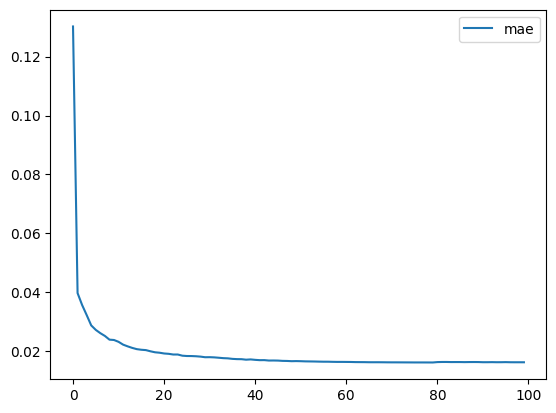

In [ ]:
sns.lineplot(history_4.history['mae'],label='mae')

In [ ]:
model_4.evaluate(valid_ds)

45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0224 - mae: 0.0224


[0.02334115095436573, 0.02334115095436573]

In [ ]:
from sklearn.metrics import r2_score
pred=model_4.predict(valid_ds)
score=r2_score(valid['rail'][40:],pred)
print(f'We have an r2 score of {score*100:.2f}%')

45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
We have an r2 score of 94.07%


# Model_5 Let's Use The WaveNet

In [ ]:
model_5=tf.keras.Sequential()
model_5.add(tf.keras.layers.Input(shape=(len,4)))
for rate in (4,8,9,10)*5:
  model_5.add(tf.keras.layers.Conv1D(filters=20*rate,kernel_size=2,padding='causal',activation='relu',dilation_rate=rate))
model_5.add(tf.keras.layers.GRU(689,return_sequences=True))
model_5.add(tf.keras.layers.GRU(689,return_sequences=False))
model_5.add(tf.keras.layers.Dense(1))
model_5.summary()

Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_90 (Conv1D)              │ (None, 40, 80)         │           720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_91 (Conv1D)              │ (None, 40, 160)        │        25,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_92 (Conv1D)              │ (None, 40, 180)        │        57,780 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_93 (Conv1D)              │ (None, 40, 200)        │        72,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_94 (Conv1D)              │ (None, 40, 80)         │        32,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_95 (Conv1D)              │ (None, 40, 160)        │        25,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_96 (Conv1D)              │ (None, 40, 180)        │        57,780 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_97 (Conv1D)              │ (None, 40, 200)        │        72,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_98 (Conv1D)              │ (None, 40, 80)         │        32,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_99 (Conv1D)              │ (None, 40, 160)        │        25,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_100 (Conv1D)             │ (None, 40, 180)        │        57,780 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_101 (Conv1D)             │ (None, 40, 200)        │        72,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_102 (Conv1D)             │ (None, 40, 80)         │        32,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_103 (Conv1D)             │ (None, 40, 160)        │        25,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_104 (Conv1D)             │ (None, 40, 180)        │        57,780 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_105 (Conv1D)             │ (None, 40, 200)        │        72,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_106 (Conv1D)             │ (None, 40, 80)         │        32,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_107 (Conv1D)             │ (None, 40, 160)        │        25,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_108 (Conv1D)             │ (None, 40, 180)        │        57,780 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_109 (Conv1D)             │ (None, 40, 200)        │        72,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_10 (GRU)                    │ (None, 40, 689)        │     1,841,697 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_11 (GRU)                    │ (None, 689)            │     2,852,460 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │           690 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,602,587 (21.37 MB)

 Trainable params: 5,602,587 (21.37 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
def lr_schedule_exp(epoch):
  if epoch<80:
    return float(tf.exp(-epoch/10.)*0.01)/3
  else:
    return 0.0001/9
learning_rate_callback=tf.keras.callbacks.LearningRateScheduler(lr_schedule_exp)
checkpoint=tf.keras.callbacks.ModelCheckpoint('model_5.keras',monitor='val_loss',mode='min',save_best_only=True,verbose=1)

In [ ]:
model_5.compile(loss='mae',
                optimizer=tf.keras.optimizers.Nadam(),
                metrics=['mae'])

In [ ]:
history_5=model_5.fit(train_ds,
            epochs=100,
            validation_data=valid_ds,
            verbose=1,callbacks=[learning_rate_callback,checkpoint])

Epoch 1/100
170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.2813 - mae: 0.2813
Epoch 1: val_loss improved from inf to 0.15314, saving model to model_5.keras
170/170 ━━━━━━━━━━━━━━━━━━━━ 65s 64ms/step - loss: 0.2807 - mae: 0.2807 - val_loss: 0.1531 - val_mae: 0.1531 - learning_rate: 0.0033
Epoch 2/100
170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.1228 - mae: 0.1228
Epoch 2: val_loss did not improve from 0.15314
170/170 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - loss: 0.1228 - mae: 0.1228 - val_loss: 0.1535 - val_mae: 0.1535 - learning_rate: 0.0030
Epoch 3/100
169/170 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.1231 - mae: 0.1231
Epoch 3: val_loss improved from 0.15314 to 0.14944, saving model to model_5.keras
170/170 ━━━━━━━━━━━━━━━━━━━━ 8s 48ms/step - loss: 0.1231 - mae: 0.1231 - val_loss: 0.1494 - val_mae: 0.1494 - learning_rate: 0.0027
Epoch 4/100
170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.1213 - mae: 0.1213
Epoch 4: val_loss improved from 0.14944 to 0.14942, saving mode

# Ι Will Make An Seq_to_seq Model To Predict At every time step the next 7 days ridership

In [ ]:
train

,day_type_enc,next_day_type_enc,bus,rail
date,,,,
2001-01-01,0.001238,0.704547,0.191308,0.091642
2001-01-02,0.999771,0.704286,0.618846,0.426020
2001-01-03,0.999755,0.704262,0.657827,0.456724
2001-01-04,0.999748,0.704253,0.697694,0.468816
2001-01-05,0.999744,0.998236,0.715732,0.475856
...,...,...,...,...
2015-12-27,0.000929,0.704446,0.224498,0.221399
2015-12-28,0.999780,0.704298,0.383119,0.410344
2015-12-29,0.999738,0.704238,0.492781,0.487793


In [ ]:
train_ds=tf.keras.utils.timeseries_dataset_from_array(train,
                                                      targets=None,
                                                      sequence_length=130+8,
                                                      batch_size=32,
                                                      shuffle=True
                                                  )
valid_ds=tf.keras.utils.timeseries_dataset_from_array(valid,
                                                      targets=None,
                                                      sequence_length=130+8,
                                                      batch_size=32
                                                      )

In [ ]:
train_ds=train_ds.map(lambda x:(x[:,:130,:],x[:,130:137,3]))
valid_ds=valid_ds.map(lambda x:(x[:,:130,:],x[:,130:137,3]))

In [ ]:
for item in train_ds.take(1):
  print(item)

(<tf.Tensor: shape=(32, 130, 4), dtype=float64, numpy=
array([[[9.99727358e-01, 7.04222393e-01, 7.14106765e-01, 5.07456108e-01],
        [9.99703195e-01, 9.97943867e-01, 6.97385717e-01, 5.52115280e-01],
        [2.95134166e-01, 1.54857103e-03, 4.85480579e-01, 3.34053743e-01],
        ...,
        [9.99659348e-01, 9.97633386e-01, 8.56963656e-01, 6.33157372e-01],
        [2.95182733e-01, 1.61127248e-03, 5.00151608e-01, 3.15771008e-01],
        [9.74020806e-04, 7.04460283e-01, 3.14445872e-01, 2.02585639e-01]],

       [[9.99699926e-01, 9.97920716e-01, 7.54749122e-01, 5.58158173e-01],
        [2.95202701e-01, 1.63705120e-03, 4.91517483e-01, 3.08254347e-01],
        [8.50492013e-04, 7.04419720e-01, 3.18524693e-01, 2.54569125e-01],
        ...,
        [2.95336587e-01, 1.80990394e-03, 5.00895060e-01, 2.57853268e-01],
        [1.05768249e-03, 7.04487754e-01, 2.98651266e-01, 1.67379062e-01],
        [9.99707860e-01, 7.04194274e-01, 8.76453423e-01, 5.43493515e-01]],

       [[9.99620607e-01, 7.

In [ ]:
model_5=tf.keras.Sequential([
    tf.keras.layers.Input(shape=(130,4)),
    tf.keras.layers.GRU(689,return_sequences=True),
    tf.keras.layers.GRU(689,return_sequences=True),
    tf.keras.layers.GRU(689),
    tf.keras.layers.Dense(7)
])
model_5.summary()

Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_5 (GRU)                     │ (None, 130, 689)       │     1,436,565 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_6 (GRU)                     │ (None, 130, 689)       │     2,852,460 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_7 (GRU)                     │ (None, 689)            │     2,852,460 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 7)              │         4,830 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,146,315 (27.26 MB)

 Trainable params: 7,146,315 (27.26 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
def lr_schedule_exp(epoch):
  if epoch<80:
    return float(tf.exp(-epoch/10.)*0.01)/3
  else:
    return 0.0001/9
learning_rate_callback=tf.keras.callbacks.LearningRateScheduler(lr_schedule_exp)
checkpoint=tf.keras.callbacks.ModelCheckpoint('model_5.keras',monitor='val_loss',mode='min',save_best_only=True,verbose=1)

In [ ]:
model_5.compile(loss='mae',
                optimizer=tf.keras.optimizers.Nadam(),
                metrics=['mae'])

In [ ]:
model_5.fit(train_ds,epochs=100,validation_data=valid_ds,verbose=1,callbacks=[learning_rate_callback,checkpoint])

Epoch 1/100
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - loss: 0.2124 - mae: 0.2124
Epoch 1: val_loss improved from inf to 0.10731, saving model to model_5.keras
167/167 ━━━━━━━━━━━━━━━━━━━━ 22s 113ms/step - loss: 0.2118 - mae: 0.2118 - val_loss: 0.1073 - val_mae: 0.1073 - learning_rate: 0.0033
Epoch 2/100
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - loss: 0.0455 - mae: 0.0455
Epoch 2: val_loss improved from 0.10731 to 0.05709, saving model to model_5.keras
167/167 ━━━━━━━━━━━━━━━━━━━━ 21s 115ms/step - loss: 0.0455 - mae: 0.0455 - val_loss: 0.0571 - val_mae: 0.0571 - learning_rate: 0.0030
Epoch 3/100
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - loss: 0.0380 - mae: 0.0380
Epoch 3: val_loss improved from 0.05709 to 0.04230, saving model to model_5.keras
167/167 ━━━━━━━━━━━━━━━━━━━━ 20s 113ms/step - loss: 0.0380 - mae: 0.0380 - val_loss: 0.0423 - val_mae: 0.0423 - learning_rate: 0.0027
Epoch 4/100
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - loss: 0.0349 - mae: 0.0349
Epoch 4: val_loss imp

In [ ]:
model_5.evaluate(valid_ds)

42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 0.0327 - mae: 0.0327


[0.03468208387494087, 0.03468208387494087]

In [ ]:
pred=model_5.predict(valid_ds)

42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step


In [ ]:
pred_df=pd.DataFrame(pred[0],index=valid.index[130:137])

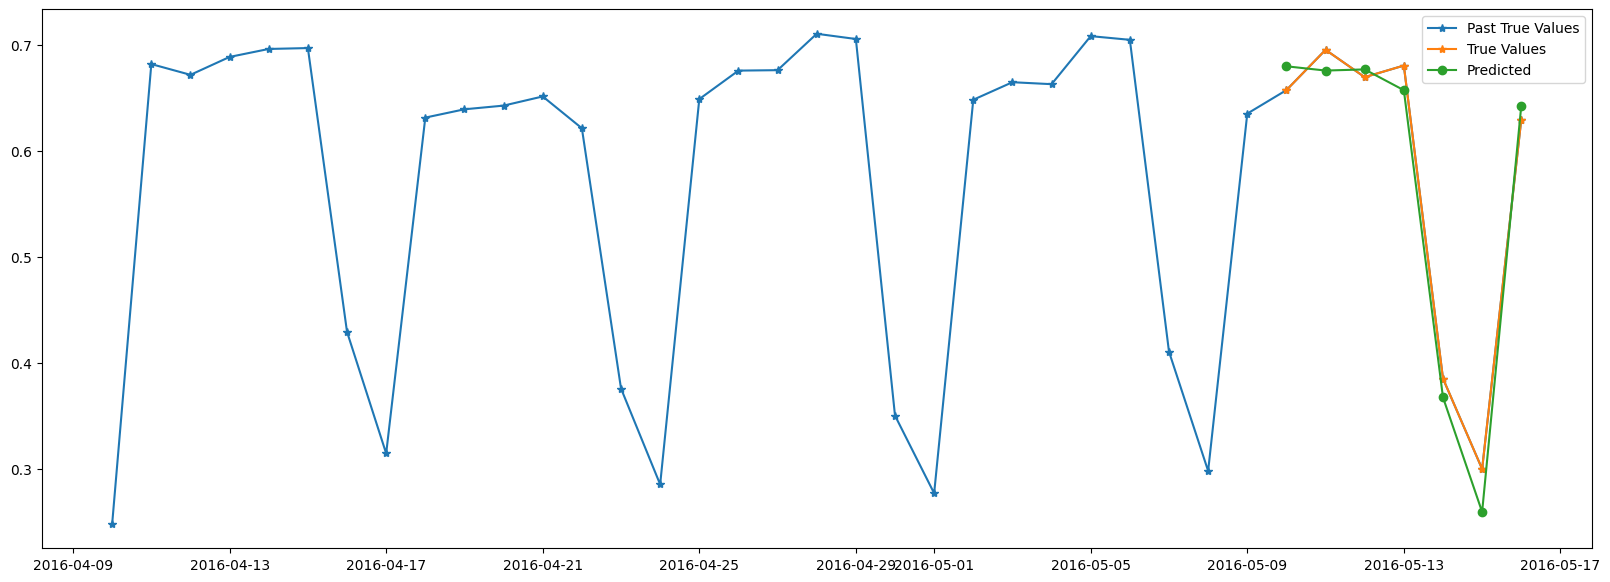

In [ ]:
plt.figure(figsize=(20,7))
plt.plot()
plt.plot(valid['rail'][100:137],label='Past True Values',marker='*')
plt.plot(valid['rail'][130:137],label='True Values',marker='*')
plt.plot(pred_df,label='Predicted',marker='o')
plt.legend()